In [1]:
import dipy

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs

In [3]:
from fenics import *
from mshr import *
#from math import pi, sin, cos, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import subprocess

In [4]:
fname = 'dMRI_data/ss-ras_data.nii.gz' 
bval_fname = 'dMRI_data/ss-ras.bval' 
bvec_fname = 'dMRI_data/ss-ras.bvec'

data, affine = load_nifti(fname)
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
dims = data.shape
print('data.shape (%d, %d, %d, %d)' % dims)

data_float = data.astype(np.float32)

dataMaxVal = int(max(data.flatten()))
dataMinVal = int(min(data.flatten()))

print('b values: ', bvals)
print('b vectors: ', bvecs)

data.shape (104, 104, 72, 32)
b values:  [  0. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700.   0. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700.]
b vectors:  [[ 0.          0.          0.        ]
 [ 0.22293058 -0.49968055 -0.83703119]
 [-0.17871778 -0.49333411 -0.85128242]
 [-0.37542525 -0.14225766 -0.91587037]
 [ 0.41157657 -0.72193778 -0.556247  ]
 [ 0.19853516 -0.93616748 -0.29012811]
 [ 0.84751403 -0.52907634 -0.04240569]
 [ 0.73912424 -0.51868695 -0.42972025]
 [ 0.43850514 -0.15385152 -0.88546205]
 [ 0.75664991 -0.17243032 -0.63067305]
 [ 0.62896943 -0.74815804  0.21132247]
 [ 0.30347744 -0.94898587  0.0855993 ]
 [ 0.28489485 -0.54959691  0.78535217]
 [ 0.62077832 -0.54730117  0.56133366]
 [ 0.97062433 -0.19699152  0.13814011]
 [ 0.83273727 -0.20222756  0.51541471]
 [-0.03439669 -0.75075191  0.65968806]
 [-0.02572841 -0.94997877  0.31125325]
 [-0.68088585 -0.5256443   0.50999278]
 [-0.36761704 -0.53581387  0.76010603]
 [-

In [5]:
parameters['allow_extrapolation'] = True

In [6]:
#Input volume number
k = 7

In [7]:
#To select well distruted (farthes pointing vectors in 3D)
def calc_distances(p0, points):
    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
    #return ((p0 - points)**2).sum(axis=1)
    
def farthestPts(pts, K):
    farthest_pts = np.zeros((K, 3))
    pts_inds = np.zeros(K)
    #farthest_pts[0] = pts[np.random.randint(len(pts))]
    farthest_pts[0] = pts[1]
    pts_inds[0] = 1
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        pts_inds[i] = np.argmax(distances)
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts, pts_inds
sub_bvecs, sub_indcs = farthestPts(bvecs, k)
print('b sub vectors: ', sub_bvecs)
print('b sub vector indecs ', sub_indcs)

b sub vectors:  [[ 0.22293058 -0.49968055 -0.83703119]
 [ 0.62077832 -0.54730117  0.56133366]
 [-0.66621846 -0.72867197  0.15871401]
 [ 0.          0.          0.        ]
 [-0.70739847 -0.15345097 -0.68995672]
 [-0.15568012  0.20317107 -0.96668768]
 [ 0.19853516 -0.93616748 -0.29012811]]
b sub vector indecs  [ 1. 13. 23.  0. 27. 20.  5.]


In [8]:
# Selecting one b0 and six b700 voxels
sub_indcs = sub_indcs.astype(int)
sub_bvals = bvals[sub_indcs]
print(sub_bvals)

sub_data = data_float[:, :, :, sub_indcs]
print(sub_data.shape)

##Save left volumes as Nifti file
#sub_data_int = sub_data.astype(int)
#subVols = nib.Nifti1Image(sub_data_int, affine=np.eye(4))
#nib.nifti1.save(subVols, os.getcwd()+'{}'.format(r'/cosine_weighted_averaging/sub_vols.nii.gz'))

#Removing input data (1+6 volumes)
left_data = np.delete(data_float, sub_indcs, axis=3)
print(left_data.shape)

##Save left volumes as Nifti file
#left_data_int = left_data.astype(int)
#predictedVols = nib.Nifti1Image(left_data_int, affine=np.eye(4))
#nib.nifti1.save(predictedVols, os.getcwd()+'{}'.format(r'/cosine_weighted_averaging/left_vols.nii.gz'))

[700. 700. 700.   0. 700. 700. 700.]
(104, 104, 72, 7)
(104, 104, 72, 25)


In [9]:
##Registration
#b0_ind = np.where(sub_bvals==0)[0]
#regis_sub_data = subprocess.run(["eddy_correct", "cosine_weighted_averaging/sub_vols.nii.gz", "cosine_weighted_averaging/registered_data/sub_data_lowb-corrected.nii.gz", str(b0_ind[0])])
#print("The exit code was: %d" % regis_sub_data.returncode)

In [10]:
#Load registrated data
#nameStr = 'LH_all_voxels/registered_data/kFrame_correct17.nii.gz'     
#sub_regis_data, sub_regis_affine = load_nifti(nameStr)
#dims_sub = sub_regis_data.shape
#print('data.shape (%d, %d, %d, %d)' % sub_regis_data.shape)
#print('Type: ', sub_regis_data.dtype)

In [11]:
#Volume Index to predict
nextIter_sub_bvecs, nextIter_sub_indcs = farthestPts(bvecs, k+1)
print('b sub vector indecs ', nextIter_sub_indcs)
nextIter_sub_indcs = nextIter_sub_indcs.astype(int)
inter_sub_indcs = [i for i in nextIter_sub_indcs if i not in sub_indcs]
if len(inter_sub_indcs) != 0: 
    left_indcs = inter_sub_indcs[0]
else:
    left_indcs = np.arange(data.shape[3])
    left_indcs = np.delete(left_indcs, sub_indcs)
    print(left_indcs)
    left_indcs = left_indcs[0]
print("Predicted volume: ", left_indcs)
bvec_volPredict = bvecs[left_indcs]
print("Prediction b vector: ", bvec_volPredict)

b sub vector indecs  [ 1. 13. 23.  0. 27. 20.  5.  9.]
Predicted volume:  9
Prediction b vector:  [ 0.75664991 -0.17243032 -0.63067305]


In [12]:
#center = Point(0.0, 0.0, 0.0)
#sphere = Sphere(center,1.0)
#mesh = generate_mesh(sphere,5) # 20 specify the resolution of the mesh
#plot(mesh)

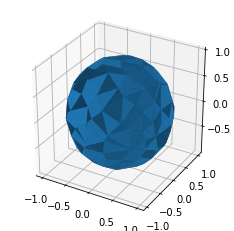

In [13]:
# Mesh and function space
#sphere = Sphere(Point(0.0, 0.0, 0.0), 1.0)
#vmesh = generate_mesh(sphere, 5)
#mesh = BoundaryMesh(vmesh, "exterior")
#plot(mesh)

#mesh = Mesh('LH/mesh.xml')
mesh = Mesh('LH/mesh_on_sphere_myself.xml')
plot(mesh)

In [14]:
for ind in nextIter_sub_indcs:
    print(ind)

1
13
23
0
27
20
5
9


In [15]:
sub_indcs

array([ 1, 13, 23,  0, 27, 20,  5])

In [16]:
bvec_volPredict = bvecs[left_indcs]
lh_coefs = np.zeros(len(sub_indcs))

for l in range(len(sub_indcs)):
    if sub_indcs[l] != 0:
        V = FunctionSpace(mesh, "P", 1)
        # get coordinates of DOFs
        dof_coords = V.tabulate_dof_coordinates()
        
        bcs = []
        for ind in sub_indcs:
            if ind!=0:
                if ind==sub_indcs[l]:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                else:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                    
        u = TrialFunction(V) 
        v = TestFunction(V)
        w = Function(V)   
        
        a=inner(grad(u),grad(v))*dx
        
        f = Constant(0.0)
        L = f*v*dx
        solve(a == L, w, bcs)
        
        lh_coefs[l] = w(bvec_volPredict)
        print(lh_coefs[l])
    else:
        lh_coefs[l] = 0

0.2796852467209501
0.12839697304633577
0.1954605533046933
0.10259296645831005
0.13804072197974976
0.15582353848996155


In [17]:
lh_coefs

array([0.27968525, 0.12839697, 0.19546055, 0.        , 0.10259297,
       0.13804072, 0.15582354])

In [18]:
np.sum(lh_coefs)

1.0000000000000004

In [19]:
inpaintedImg_3D = np.zeros((dims[0], dims[1], dims[2]))

for i in range(len(sub_indcs)):
    inpaintedImg_3D = inpaintedImg_3D + lh_coefs[i]*data_float[...,sub_indcs[i]]
inpaintedImg_3D = inpaintedImg_3D/np.sum(lh_coefs)

In [20]:
min(inpaintedImg_3D.flatten())

0.0

In [21]:
bvec_volPredict

array([ 0.75664991, -0.17243032, -0.63067305])

In [22]:
ni_img = nib.Nifti1Image(inpaintedImg_3D, affine=affine)
nib.save(ni_img, "fast_qspace_LH_volume_image_on_sphere_9_dely.nii")

In [48]:
np.array_equal(data_float[...,sub_indcs[1]], data_float[...,13])

True

In [47]:
sub_indcs[1]

13

In [23]:
array_u = nodal_values_u = w.vector()
vertex_values_u = w.compute_vertex_values()

In [24]:
print(array_u)

In [25]:
for i in range(len(array_u)):
    print(array_u[i])

0.13266499609288676
0.23974683441574657
0.07931118497001105
0.07245093818879263
0.1558273218887098
0.0
0.16823499119297106
0.37947694250273706
0.6530824123540476
0.2814554369405757
0.21649661808594767
0.11172596168803318
0.02671912815933862
0.059457919398902444
0.047098303289666896
0.08736888411266487
0.10184944461261503
0.11337396991607354
0.1536051940299179
0.2652367684395055
0.44013112985625286
1.0
0.4058488831526997
0.18965081605010664
0.18352051181741835
0.11816414948591186
0.10222500467313758
0.0
0.05142121351161297
0.03530036059888849
0.0
0.08079254765888282
0.1558235384899616
0.2485752566614744
0.33885860583013155
0.5751111733196548
0.4875018857525825
0.24119923166454307
0.07957968344626146
0.10104190739530067
0.08285918445678843
0.07092110338870736
0.060469465847065286
0.044093777529570485
0.07601272321460138
0.04339880707571452
0.08502472380411574
0.10703235887311194
0.09512594485904219
0.12439438308642245
0.16305214521187716
0.2324629459031707
0.21048921068899598
0.207601868

In [26]:
min(array_u)

0.0

In [27]:
len(array_u)

161

In [28]:
bvecs[1][0]

0.22293058

In [29]:
bvecs[1][2]

-0.83703119

In [30]:
data_float[63,54,30,1]

43.0

In [31]:
data_float[63,54,30,14]

46.0

In [32]:
data_float[63,54,30,17]

13.0

In [33]:
data_float[63,54,30,20]

48.0

In [34]:
data_float[63,54,30,22]

25.0

In [35]:
data_float[63,54,30,29]

52.0

In [36]:
#error_L2 = errornorm(u_D, w, 'L2')
#vertex_values_u_D = u_D.compute_vertex_values(mesh)
#vertex_values_u = w.compute_vertex_values(mesh)
#error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
#print(error_max)
#print(error_L2)

In [37]:
bvecs[27]

array([-0.70739847, -0.15345097, -0.68995672])

In [38]:
x_point = Point(*[bvecs[27]])
mesh.bounding_box_tree().compute_first_entity_collision(x_point)

4294967295

In [39]:
#mesh.bounding_box_tree().compute_closest_point(x_point)

In [40]:
inpaintedImg_3D.shape

(104, 104, 72)

In [41]:
max(inpaintedImg_3D.flatten())

436.40958404541

In [42]:
for ind in sub_indcs:
    if ind!=0:
        # find nearest DOF:
        dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
        print('dof {}, x = {}'.format(dof, dof_coords[dof]))
        dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
        print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

dof 5, x = [ 0.22293058 -0.49968055 -0.83703119]
dof 157, x = [-0.22293058  0.49968055  0.83703119]
dof 82, x = [ 0.62077832 -0.54730117  0.56133366]
dof 76, x = [-0.62077832  0.54730117 -0.56133366]
dof 60, x = [-0.66621846 -0.72867197  0.15871401]
dof 73, x = [ 0.66621846  0.72867197 -0.15871401]
dof 27, x = [-0.70739847 -0.15345097 -0.68995672]
dof 135, x = [0.70739847 0.15345097 0.68995672]
dof 30, x = [-0.15568012  0.20317107 -0.96668768]
dof 158, x = [ 0.15568012 -0.20317107  0.96668768]
dof 21, x = [ 0.19853516 -0.93616748 -0.29012811]
dof 152, x = [-0.19853516  0.93616748  0.29012811]


In [43]:
bvecs

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.22293058, -0.49968055, -0.83703119],
       [-0.17871778, -0.49333411, -0.85128242],
       [-0.37542525, -0.14225766, -0.91587037],
       [ 0.41157657, -0.72193778, -0.556247  ],
       [ 0.19853516, -0.93616748, -0.29012811],
       [ 0.84751403, -0.52907634, -0.04240569],
       [ 0.73912424, -0.51868695, -0.42972025],
       [ 0.43850514, -0.15385152, -0.88546205],
       [ 0.75664991, -0.17243032, -0.63067305],
       [ 0.62896943, -0.74815804,  0.21132247],
       [ 0.30347744, -0.94898587,  0.0855993 ],
       [ 0.28489485, -0.54959691,  0.78535217],
       [ 0.62077832, -0.54730117,  0.56133366],
       [ 0.97062433, -0.19699152,  0.13814011],
       [ 0.83273727, -0.20222756,  0.51541471],
       [-0.03439669, -0.75075191,  0.65968806],
       [-0.02572841, -0.94997877,  0.31125325],
       [-0.68088585, -0.5256443 ,  0.50999278],
       [-0.36761704, -0.53581387,  0.76010603],
       [-0.15568012,  0.20317107, -0.966

In [44]:
for ind in sub_indcs:
    print(ind)

1
13
23
0
27
20
5
